# Media Mix Modeling 

This project creates a media mix model to extract the impact of different media on a company's sales. The model is built using simulated dataset and is based on the Bayesian methods proposed by Uber's team Ng, Wang and Dai (2021). It also takes inspiration from some excellent posts on such models by Dr. Juan Camilo Orduz at Wolt. 


### Model

The model proposed by Ng,, Wand et all has KTR (kernel-based Time-varying regression) as its main feature. The core concept of KTR is the use of latent (hidden) variables to create a smooth time varying representation of model coefficients. These smooth representations are Kernel Smooths. The latent variables can be said to be inspired or similar to the basis functions in a spline regression. An excellent resource to understand split regression is this Youtube video by Analytics University.

The model states that the time series of a response variable like sales can be mathematically represented as:

y(t) = Trend(t) + Seasonality(t) + media_effect(t) + noise(t)

Each component itself is a time-series. The approach to model each individual component would be as follows:

Trend & Seasonality: To be developed using ARIMA models
Media Effect: To be modeled using KTR model proposed by Ng, Wang et all.




In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, norm


In [2]:
mmm_data = pd.read_csv("advertising.txt")

mmm_data.head()


,Week,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
mmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Week       200 non-null    int64  
 1   TV         200 non-null    float64
 2   radio      200 non-null    float64
 3   newspaper  200 non-null    float64
 4   sales      200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


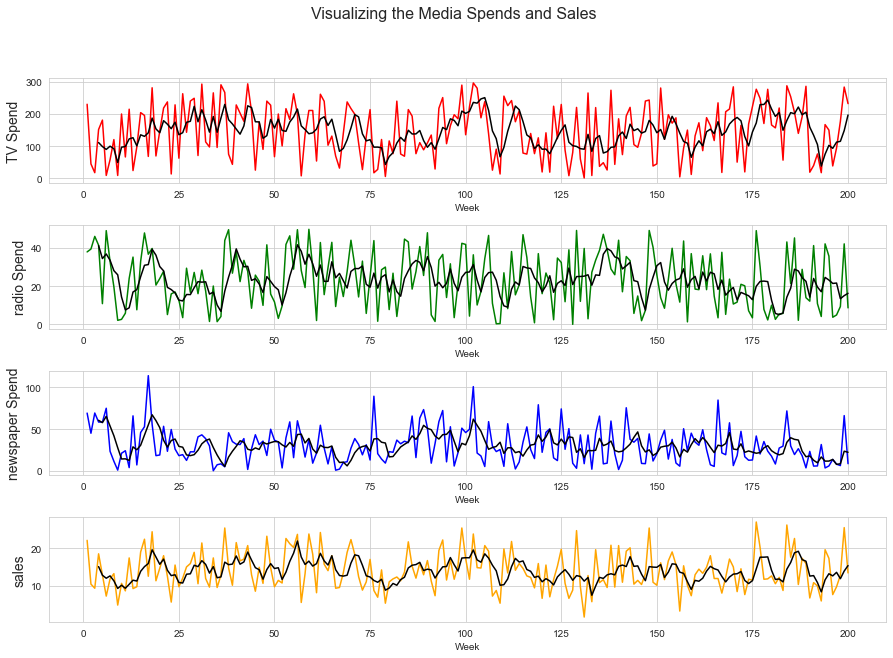

In [37]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(4,1, figsize = (15,10))
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
fig.subplots_adjust(wspace=0.3, hspace=0.4)

for i in range(4):
    ax = axes.flatten()[i]
    ax.plot(mmm_data['Week'], mmm_data.iloc[:, i+1], c = colors[i])
    ax.plot(mmm_data['Week'], mmm_data.iloc[:, i+1].rolling(window = 4).mean(), c = 'black')
    
    if i < 3:
        ax.set_ylabel(mmm_data.columns[i+1]+" Spend", fontsize = 14)
    else:
        ax.set_ylabel(mmm_data.columns[i+1], fontsize = 14)
    ax.set_xlabel("Week")

fig.suptitle("Visualizing the Media Spends and Sales", fontsize = 16)
    
plt.show()



Visually, the sales graph seems to have more similarity to TV spends than spends on radio and newspaper. Let's check out the correlation of sales with each of the spends.


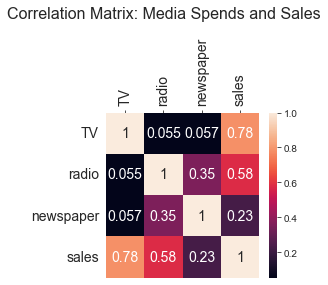

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
ax=sns.heatmap(mmm_data.drop(['Week'], axis=1).corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Media Spends and Sales", fontsize=16)
plt.tight_layout()
plt.show()


The above matrix confirms what we saw visually that the sales has a stronger relation with TV spends, with a correlation coefficient of 0.78 with TV, 0.58 with radio and only 0.23 with newspaper.


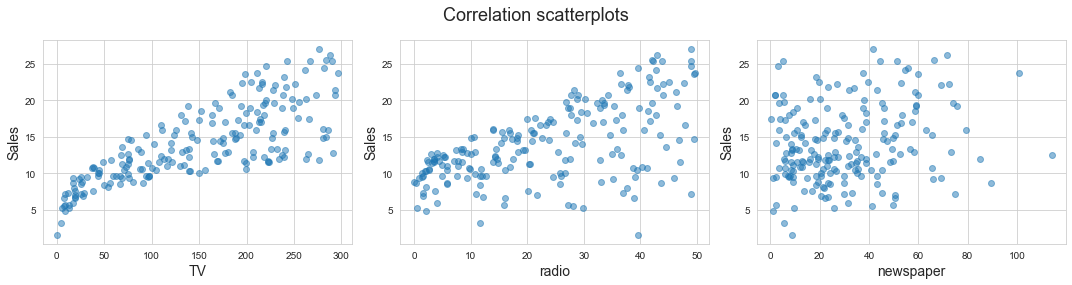

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(15,4), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)

plt.suptitle("Correlation scatterplots", fontsize=18)

for i, col in enumerate(list(mmm_data.columns[1:4])):
    ax[0][i].scatter(x = col, y = "sales", data=mmm_data, alpha=0.5)
    ax[0][i].set_xlabel(col, fontsize=14)
    ax[0][i].set_ylabel("Sales", fontsize=14)

plt.tight_layout()
plt.show()

    

We notice in the above scatter plots that while Sales has a strong correlation with TV spends, the sales still vary in a broad range as TV spends go up. E.g. At a TV spend of 200, the sales vary between 10 and 25, that's a 2.5x variation! 

To better model the relationship between sales and media spends, we start by using time-series analysis to first under stand the trend and seasonality components.

The data is available for 200 weeks, for simplicity we make following assumptions:

* Each year is 50 weeks
* Each month is 4 weeks, except June and Dec that are 5 weeks



In [76]:
mmm_data['year'] = round(mmm_data['Week'] // 50.01 + 1)
mmm_data['year'] = mmm_data['year'].astype("int8")

mmm_data['month'] = round((mmm_data['Week'] - mmm_data['Week']//25) // 4.001 + 1) - 12 * (mmm_data['year'] - 1)
mmm_data['month'] = mmm_data['month'].astype("int8")
mmm_data.head(10)

,Week,TV,radio,newspaper,sales,year,month
0,1,230.1,37.8,69.2,22.1,1,1
1,2,44.5,39.3,45.1,10.4,1,1
2,3,17.2,45.9,69.3,9.3,1,1
3,4,151.5,41.3,58.5,18.5,1,1
4,5,180.8,10.8,58.4,12.9,1,2
5,6,8.7,48.9,75.0,7.2,1,2
6,7,57.5,32.8,23.5,11.8,1,2
7,8,120.2,19.6,11.6,13.2,1,2
8,9,8.6,2.1,1.0,4.8,1,3
9,10,199.8,2.6,21.2,10.6,1,3


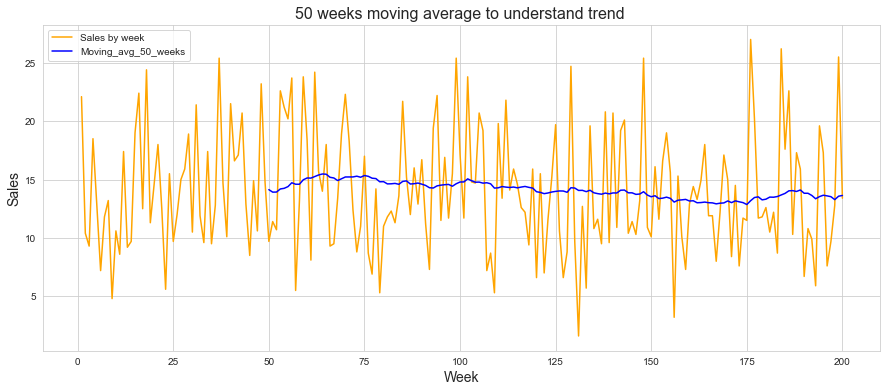

In [50]:

# We plot the moving 50 weeks average to understand trend

plt.figure(figsize = (15,6))

plt.plot(mmm_data['Week'], mmm_data["sales"], c = 'orange', label = 'Sales by week')
plt.plot(mmm_data['Week'], mmm_data["sales"].rolling(window = 50).mean(), c = 'blue', label = "Moving_avg_50_weeks")


plt.ylabel("Sales", fontsize = 14)
plt.xlabel("Week", fontsize = 14)
plt.legend()

plt.title("50 weeks moving average to understand trend ", fontsize = 16)
    
plt.show()



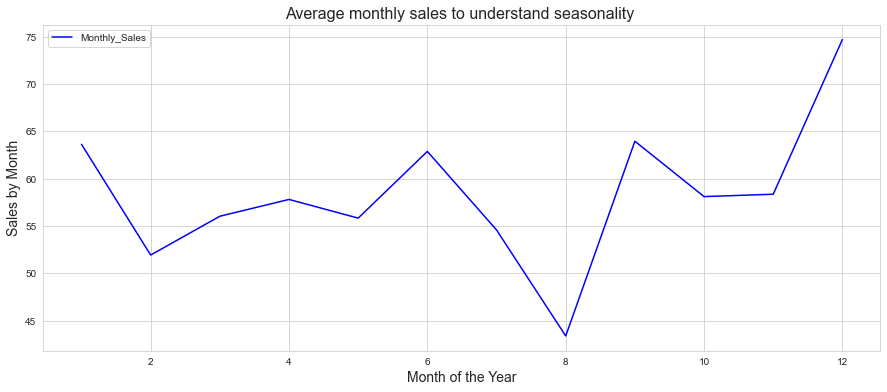

In [84]:
sales_monthly = pd.DataFrame(mmm_data.groupby(['year', 'month'])['sales'].sum()).reset_index()
avg_by_month = pd.DataFrame(sales_monthly.groupby('month')['sales'].mean()).reset_index()

plt.figure(figsize = (15,6))

plt.plot(avg_by_month['month'], avg_by_month['sales'], c = 'blue', label = 'Monthly_Sales')

plt.ylabel("Sales by Month", fontsize = 14)
plt.xlabel("Month of the Year", fontsize = 14)
plt.legend()

plt.title("Average monthly sales to understand seasonality ", fontsize = 16)
    
plt.show()

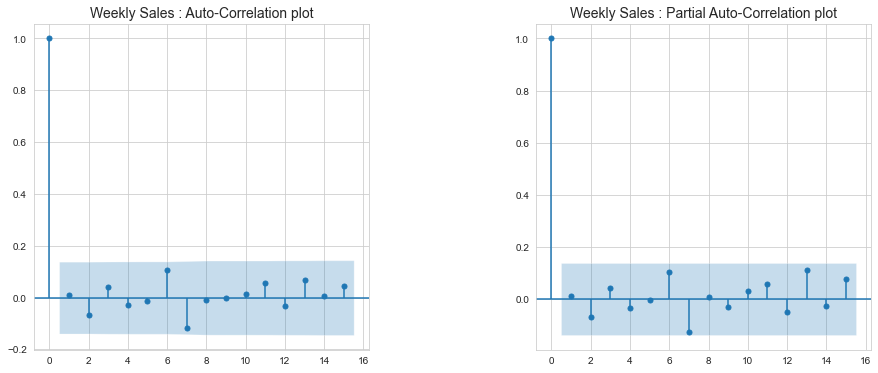

In [91]:
fig, axes = plt.subplots(1,2, figsize =(15,6), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)

plot_acf(mmm_data['sales'], alpha = 0.05, lags = 15, ax = axes[0][0])
plot_pacf(mmm_data['sales'], alpha = 0.05, lags = 15, ax = axes[0][1])

axes[0][0].set_title("Weekly Sales : Auto-Correlation plot", fontsize=14)
axes[0][1].set_title("Weekly Sales : Partial Auto-Correlation plot", fontsize=14)

plt.show()

    
                         

From the above auto-correlation(acf) and partial auto-correlation(pacf) plots of weekly sales data, both acf and pacf cut-off at a single lag. This means that weekly sales cannot be modelled as a AR (Auto Regression) or MA (Moving Average) process.

Let's analyse the monthly data. 


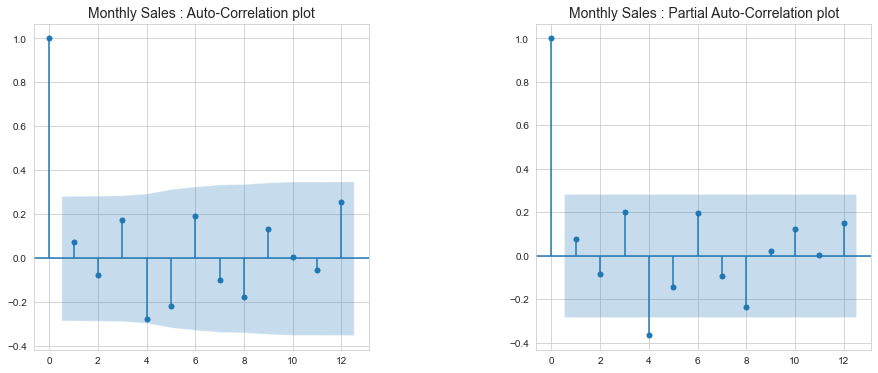

In [95]:
fig, axes = plt.subplots(1,2, figsize =(15,6), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)

plot_acf(sales_monthly['sales'], alpha = 0.05, lags = 12, ax = axes[0][0])
plot_pacf(sales_monthly['sales'], alpha = 0.05, lags = 12, ax = axes[0][1])

axes[0][0].set_title("Monthly Sales : Auto-Correlation plot", fontsize=14)
axes[0][1].set_title("Monthly Sales : Partial Auto-Correlation plot", fontsize=14)

plt.show()


For the monthly sales data, pacf does show a slightly significant lag at 4. Let's also use the Augmented Dicky Fuller test to determine whether the weekly and monthly sales are stationary (random) or not.


In [96]:
results_weekly = adfuller(mmm_data["sales"])
results_monthly = adfuller(sales_monthly["sales"])

print('p-values of Aug. Dickey Fuller test')
print(f'for weekly_sales: p-value = {results_weekly[1]:4.4f}')
print(f'for monthly_sales: p-value = {results_monthly[1]:4.4f}')


p-values of Aug. Dickey Fuller test
for weekly_sales: p-value = 0.0000
for monthly_sales: p-value = 0.1315


Based on the p-values, the weekly sales clearly seems stationary. However, the monthly sales do not appear to be totally random. Let's try to decompose the monthly sales into trend, seasonal & residual pattern.  


In [107]:
decomposition = sm.tsa.seasonal_decompose(sales_monthly["sales"], period = 12)


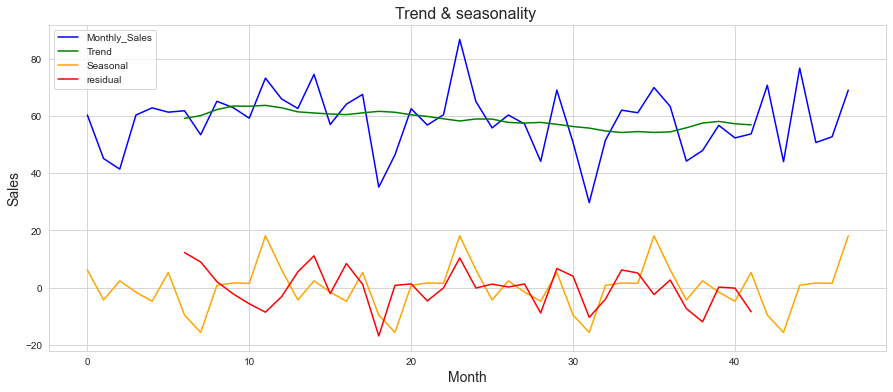

In [106]:
plt.figure(figsize = (15,6))

plt.plot(sales_monthly['sales'], c = 'blue', label = 'Monthly_Sales')
plt.plot(decomposition.trend, c = 'green', label = 'Trend')
plt.plot(decomposition.seasonal, c = 'orange', label = 'Seasonal')
plt.plot(decomposition.resid, c = 'red', label = 'residual')

plt.ylabel("Sales", fontsize = 14)
plt.xlabel("Month", fontsize = 14)
plt.legend()

plt.title("Trend & seasonality ", fontsize = 16)
    
plt.show()


From the above chart, the following can be observed: 
1) The overall trend is declining very gradually

2) The seasonality and residual components are roughly of the same order and track pretty closely as well. It seems the residual component is quite significant as the result of media impact on sales.

So next we look at understand the media impact using the KTR model.
